# Topic 4: Scipy and Numerical Techniques

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We are now ready to apply some of our basic know-how to basic numerical problems like finding solutions of equations, ODEs, and integrating.   

Before we get started with examples, we have to learn a useful trick involving lambda functions.  There is some deep origin of this idea in computer science, but our superficial level, they give us a way of defining a function while we are doing something else

Here for example, is a function that adds x and y

In [2]:
def add(x,y):
    return x+y
add(1,2)

3

We can do the same wit a lambda function

In [3]:
lambda x,y:x+y

<function __main__.<lambda>(x, y)>

So for I have just created the fucntion without giving it a name.  I can act on it too by

In [4]:
(lambda x,y:x+y)(3,5)

8

So we can think of lambda x,y: as the same thing as add(x,y) but we never stopped to define it.  At this moment, it might seem strange that we would need such a thing.  However, when it comes to solving equations, the arguements of our numerical technique is a function! We integrate functions and minimize functions, for example, so if we have a code that does that, the input is a function, not a piece of data.  lambda lets us do this easily.

### Newton's method

The best way to understand both how these libraries work and what they do is to try to solve a simple equation numerically. For example, let's consider the quadratic equation $x^2 +2x +1 =0$.  We know the solution already, $x=-1$, but this will be a good check to our method.

In [7]:
from scipy import optimize

In [8]:
def f(x):
    return x**2+2*x+1

In [9]:
optimize.newton(f,1)

-0.9999999805834525

Okay, so it finds the solution pretty well.  We can see we could have done the same directly with our lambda function

In [10]:
optimize.newton(lambda x:x**2+2*x+1,1)

-0.9999999805834525

This is why it is nice to have these lambda functions, because it saves us space so that we aren't defining all kinds of boring functions.  We save our functions for things that are actually useful

Coming back to our problem: what do we think of this answer?  This is a pretty simple equation and while we are close, this is not just some machine precision error, since there are many incorret digits.  What is going on and how can we do better?

Let's make our own Newton's method code and figure out what's going on.  First, this piece of code took a function as an input.  So we must be able to define a function where the name of the function is the input:

In [11]:
def test_func(func): #func is the name of some function that take 2 inputs
    return func(1,2) #return the function evaluated at (1,2)

In [12]:
test_func(add)  # Yay! It works

3

When one function uses another function as its arguement, that is when we can use the lambda function instead:

In [13]:
test_func(lambda x,y:x**2+100*y)

201

So we know how to feed a function to another function.  But what exactly are we trying to do? Newton's method is supposed to take our function and approximate it as a line based on the point we start $x_0$, 
$$y = f'(x_0)(x-x_0) + f(x_0)$$  
It then finds the point where $y=0$, we'll call that $x_1$, whose solution is
$$x_1 = x_0 - f(x_0)/f'(x_0)$$
We can guess this is probably close to the solution than where we started, so let's use repeat with $x_1 \to x_0$

Problem: if I want to make a code that does this, I need to tell it when to stop.  Otherwise it will just repeat forever.  For that there are two options: stop when my answer is close enough to zero or stop after some fixed number of steps (or what ever comes first)

In [14]:
def my_newton(f,fprime,x0,err):
    x1=x0-f(x0)/float(fprime(x0)) # new point according to newton
    if abs(f(x1))>err:  # need the absolute value here
        print(f(x1))
        return my_newton(f,fprime,x1,err) # repeat if the error is too large
    else:
        return x1 # return x1 when we are happy

In [20]:
my_newton(f,lambda x:2*x+2,10,0.00000001)

30.25
7.5625
1.890625
0.47265625
0.1181640625
0.029541015625
0.00738525390625
0.0018463134765625
0.000461578369140625
0.00011539459228515625
2.8848648071289062e-05
7.212162017822266e-06
1.8030405044555664e-06
4.507601261138916e-07
1.126900315284729e-07
2.8172507882118225e-08


-0.9999160766601562

Wow!  That's pretty cool.  So what did we learn? This method needs two things that we didn't feed the scipy function: (a) the derivative of f and (b) a measure of when to stop.  Presumably those are options inside the function that we didn't use?

Scipy isn't going to calculate derivatives for us, so it must be approximating the derivative some other way.  Indeed that is what's happening: if you don't provide it with the derivative, it uses something called the secant method.  To use the true Newton's method, you need to give it the derivative as well:

In [21]:
newton1=optimize.newton(lambda x:x**2+2*x+1,10,fprime=lambda x:2*x+2)
print(newton1)

-0.9999999893281472


In [24]:
sectan1=optimize.newton(lambda x:x**2+2*x+1,10)
print(sectan1)

-0.999999984901414


In [25]:
abs(newton1-sectan1)

4.426733202222977e-09

First,let's make a guess that the error is set at $10^{-16}$ because we are using 16 bit numbers:

In [26]:
myresult=my_newton(f,lambda x:2*x+2,10,10**(-16))
print(myresult)

30.25
7.5625
1.890625
0.47265625
0.1181640625
0.029541015625
0.00738525390625
0.0018463134765625
0.000461578369140625
0.00011539459228515625
2.8848648071289062e-05
7.212162017822266e-06
1.8030405044555664e-06
4.507601261138916e-07
1.126900315284729e-07
2.8172507882118225e-08
7.043126970529556e-09
1.760781742632389e-09
4.4019543565809727e-10
1.1004885891452432e-10
2.751221472863108e-11
6.87805368215777e-12
1.7195134205394424e-12
4.298783551348606e-13
1.0746958878371515e-13
2.6867397195928788e-14
6.661338147750939e-15
1.6653345369377348e-15
4.440892098500626e-16
1.1102230246251565e-16
-0.9999999945297885


In [27]:
newton1-myresult

5.201641339880325e-09

This seems like a good guess, but when we look at the documention, it seems more like what they did was stop when the difference between x1 and x0 gets small.  It takes an optional input called "tol" whose default is 1.48e-08.  Let's see what happens if we do that instead:

In [28]:
def my_newton2(f,fprime,x0,err):
    x1=x0-f(x0)/float(fprime(x0)) # new point according to newton
    if abs(x1-x0)>err:  # need the absolute value here
        print(f(x1))
        return my_newton2(f,fprime,x1,err) # repeat if the error is too large
    else:
        return x1

In [29]:
myresult2=my_newton2(f,lambda x:2*x+2,10,1.48e-08)
print(myresult2)

30.25
7.5625
1.890625
0.47265625
0.1181640625
0.029541015625
0.00738525390625
0.0018463134765625
0.000461578369140625
0.00011539459228515625
2.8848648071289062e-05
7.212162017822266e-06
1.8030405044555664e-06
4.507601261138916e-07
1.126900315284729e-07
2.8172507882118225e-08
7.043126970529556e-09
1.760781742632389e-09
4.4019543565809727e-10
1.1004885891452432e-10
2.751221472863108e-11
6.87805368215777e-12
1.7195134205394424e-12
4.298783551348606e-13
1.0746958878371515e-13
2.6867397195928788e-14
6.661338147750939e-15
1.6653345369377348e-15
4.440892098500626e-16
-0.9999999893281472


In [30]:
newton1

-0.9999999893281472

In [31]:
newton1-myresult2

0.0

We hit exactly the same number as Scipy! We can even get back to our old answer in scipy by replacing 

In [32]:
newton2=optimize.newton(lambda x:x**2+2*x+1,10,fprime=lambda x:2*x+2,tol=10**(-16))

In [33]:
newton2-myresult

0.0

Now the one thing that is nice about scipy is that it has more methods built in. We have a pretty good idea of what scipy is doing, although it is definitely coded up in a better way that is probably faster and can handle situations where we don't actually converge (e.g. scipy has a max number of iterations so it doesn't get stuck in an infinite loop).  Yet, based on what we have seen, we can imagine that if we gave it more information about the function, it could probably do better.  For example, we could improve Newton's method to use the second derivative too!  Scipy has this built in for us

In [34]:
fprime2=optimize.newton(lambda x:x**2+2*x+1,10,fprime=lambda x:2*x+2,fprime2=lambda x:2.,tol=10**(-16))
print(fprime2)

-0.9999999957639969


In [35]:
print(fprime2+1)
print(newton1+1)

4.236003103841313e-09
1.0671852845867136e-08


For all our effort, it seems like we have hit a wall.  We can't do much better than what we have.  What's the problem?  Right now we have hit the point where the difference between x1 and x0 is 10^(-16) which is around the machine error for generic floating point numbers.  Presumably if we want to do better, we are going to have to make the working precision higher.

In [36]:
my_newton2(f,lambda x:2*x+2,10,1.48e-64)

30.25
7.5625
1.890625
0.47265625
0.1181640625
0.029541015625
0.00738525390625
0.0018463134765625
0.000461578369140625
0.00011539459228515625
2.8848648071289062e-05
7.212162017822266e-06
1.8030405044555664e-06
4.507601261138916e-07
1.126900315284729e-07
2.8172507882118225e-08
7.043126970529556e-09
1.760781742632389e-09
4.4019543565809727e-10
1.1004885891452432e-10
2.751221472863108e-11
6.87805368215777e-12
1.7195134205394424e-12
4.298783551348606e-13
1.0746958878371515e-13
2.6867397195928788e-14
6.661338147750939e-15
1.6653345369377348e-15
4.440892098500626e-16
1.1102230246251565e-16
0.0


-0.9999999945297885

Let's try increasing the working precision of our code using high precision numbers

In [37]:
from decimal import Decimal

In [38]:
Decimal(0.1)

Decimal('0.1000000000000000055511151231257827021181583404541015625')

In [42]:
def my_newton3(f,fprime,x0,err):
    xs=Decimal(x0)
    x1=xs-Decimal(f(xs))/Decimal(fprime(xs)) # new point according to newton
    if abs(Decimal(f(x1)))>Decimal(err):  # need the absolute value here
        print(Decimal(f(x1)))
        return my_newton3(f,fprime,x1,err) # repeat if the error is too large
    else:
        return x1

In [43]:
my_newton3(f,lambda x:2*x+2,10,1.48e-64)

30.25
7.5625
1.890625
0.47265625
0.1181640625
0.029541015625
0.00738525390625
0.0018463134765625
0.000461578369140625
0.00011539459228515625
0.0000288486480712890625
0.000007212162017822265625
0.00000180304050445556640625
4.507601261138916015625E-7
1.126900315284729003906E-7
2.81725078821182250973E-8
7.0431269705295562748E-9
1.7607817426323890684E-9
4.401954356580972670E-10
1.100488589145243165E-10
2.75122147286310790E-11
6.8780536821577699E-12
1.7195134205394430E-12
4.298783551348607E-13
1.074695887837150E-13
2.68673971959283E-14
6.7168492989822E-15
1.6792123247455E-15
4.198030811861E-16
1.049507702966E-16
2.62376925747E-17
6.5594231434E-18
1.6398557855E-18
4.099639466E-19
1.024909865E-19
2.56227470E-20
6.4056866E-21
1.6014220E-21
4.003550E-22
1.000887E-22
2.50223E-23
6.2560E-24
1.5641E-24
3.905E-25
9.78E-26
2.46E-26
5.6E-27
1.5E-27
6E-28


Decimal('-0.9999999999999890669998056123')

In [44]:
Decimal(newton1+1)

Decimal('1.067185284586713578391936607658863067626953125E-8')

In [45]:
Decimal('-0.9999999999999890669998056123')-Decimal(-1)

Decimal('1.09330001943877E-14')

So what are the morals of this exercise: 

(1) you may not know exactly how things are coded inside numpy or scipy, you should be able to get a pretty good idea how they work 

(2) numerical techniques always have some error associated with them.  You can learn a lot about a code by understanding what controls the size of the error and trying to make it smaller 

(3) there are lots more options built into a scipy solver than what you would want to code yourself.  But, the simplest implementations are often pretty close to what you do know how to code up yourself.  The complicated options are usually just the simple idea extended to higher order (more derivatives, more grid points, higher order polynomial extrapolations, etc)

## Interpolation

In [46]:
from scipy import interpolate

Sometimes you don't actually have the analytic form of a function you want to use. Instead you might have some raw data.  Alternatively, you have the function but calculating it is so slow you need to pre-compute it at a bunch of points before you can use it in some other applications (like integrating, equation solving, etc). 

This is when interpolation is super helpful.  Interpolation is just a rule for filling in the gaps in your function based on the data you have.  

In [73]:
xI=np.linspace(0,np.pi,40)
yI=np.sin(2*xI**2)
#print(yI)

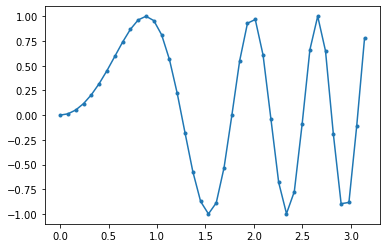

In [74]:
plt.plot(xI,yI,".",ls="-")
plt.show()

So that is our data.  Now we want to make a function that is defined on the entire range between the endpoints of our data

Let's just try the 1d interpolate function out of the box and see what it does

In [75]:
f_try = interpolate.interp1d(xI, yI)

In [76]:
x_fine=np.linspace(0,np.pi,400)

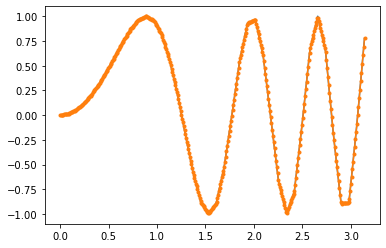

In [77]:
plt.plot(xI,yI)
plt.plot(x_fine,f_try(x_fine),".",ls="-")
plt.show()

Okay - so it looks like our default function is just drawing straight lines between the points.  This is exaclty what our plot is doing, and so we get the same sharp corners.  But if we fit with a polynomial between several points, we will get a smoother looking result.  E.g. using a cubic polynomial:

In [78]:
f_cube= interpolate.interp1d(xI, yI,kind='cubic')

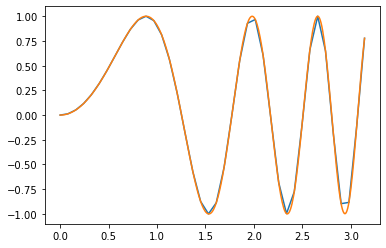

In [79]:
plt.plot(xI,yI)
plt.plot(x_fine,f_cube(x_fine))
plt.show()

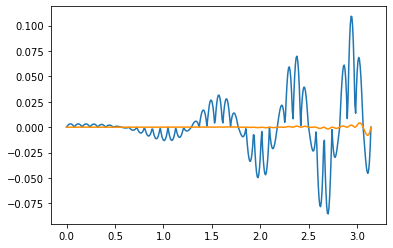

In [80]:
plt.plot(x_fine,f_try(x_fine)-np.sin(2*x_fine**2))
plt.plot(x_fine,f_cube(x_fine)-np.sin(2*x_fine**2),color='darkorange')
plt.show()

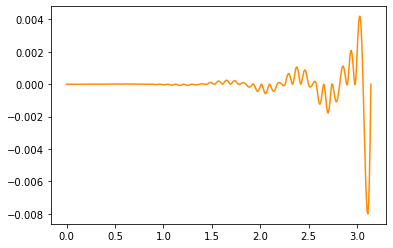

In [81]:
plt.plot(x_fine,f_cube(x_fine)-np.sin(2*x_fine**2),color='darkorange')
plt.show()

So we see that our initial function was making about a 10% error.  Using a cubic instead, we get less than 1%.  In fact, for the early points we do really well:

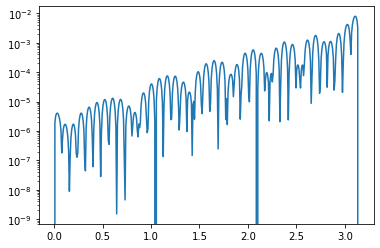

In [82]:
plt.plot(x_fine,np.abs(f_cube(x_fine)-np.sin(2*x_fine**2)))
plt.yscale('log')
plt.show()

So we are getting 1 part in a 100 000 up to about $x=1$ using only 40 data points for the full range of $[0,\pi]$

Notice that the interpolation is a function.  So we can also use this function inside of our solving code:

In [83]:
optimize.newton(f_cube,1)

1.2532996656450621

In [84]:
np.sin(2*1.2532996656450606**2)

7.254977768854082e-05

### Operations on functions / interpolations

One of the central reasons to use a spline is to a approximate a quantity we don't know exactly.  For example, Scipy has a built in function that computes a numerical derivative

In [88]:
from scipy.misc import derivative

In [89]:
def g(x):
    return x**3

In [90]:
derivative(g,1,dx=1e-5)

3.000000000097369

We could make our own very simple version:

In [91]:
def my_derivative(g,x0,dx):
    return (g(x0+dx)-g(x0-dx))/(2*dx)

In [92]:
my_derivative(g,1,dx=1e-5)

3.000000000097369

We matched the result exactly.  Of course, that is just the default, derivative has many ways to improve. E.g. we can include more than just the difference of two poitns but include more points:

In [93]:
derivative(g,1,dx=1e-5,order=7)

3.0000000000075104

Of course, we notice that this just returns a number for a single point.  However, if we wanted the derivative as a function we could just take a bunch of derivatives and make an interpolating function:

In [94]:
def h(x):
    return np.sin(2*x**2)

In [95]:
dh=np.zeros(len(xI))
for i in range(len(xI)):
    dh[i]=derivative(h,xI[i],dx=1e-5,order=7)
dh_fnc=interpolate.interp1d(xI,dh,kind='cubic')

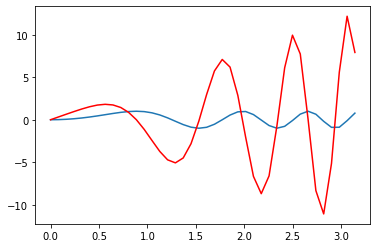

In [96]:
plt.plot(xI,h(xI))
plt.plot(xI,dh_fnc(xI),color='red')

Now we can look for maxima

In [97]:
max_h=optimize.newton(dh_fnc,1.2)
print(max_h)

0.8862269058150536


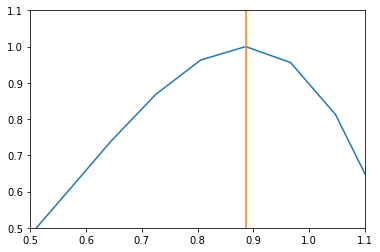

In [98]:
plt.plot(xI,h(xI))
plt.plot([max_h,max_h],[-1,1.5])
plt.xlim(0.5,1.1)
plt.ylim(0.5,1.1)
plt.show()

## Special Functions

A common thing one encounters in physics is the need to use special functions.  Many of these are implemented in scipy for us:

In [99]:
from scipy import special as sp

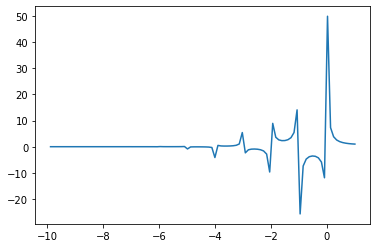

In [100]:
x=np.linspace(-10,1,102)
plt.plot(x,sp.gamma(x))

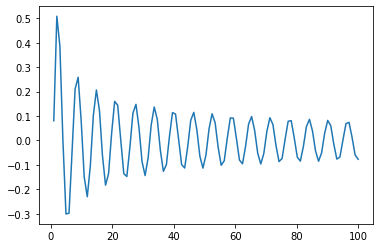

In [101]:
x=np.linspace(0,100,102)
plt.plot(x,sp.y0(x))

We don't have a particular use for them right now, but this is something you will need in most scientific applications.

It is also worth noting that these functions are defined in terms of complex arguments as well:

In [102]:
sp.gamma(-1+0.1j)

(-0.41779063569432046+9.860287232314409j)

The behavior of functions for complex arguments is a very important subject. 

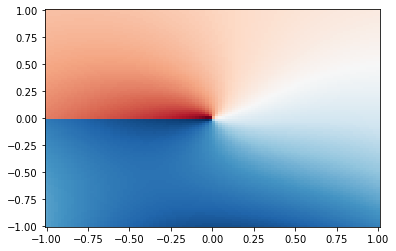

In [106]:
x=y=np.linspace(-1,1,102)
X,Y=np.meshgrid(x,y)
plt.pcolor(X,Y,np.real(sp.hankel1(0.2,X+(0+1j)*Y)),cmap='RdBu',shading='auto')

Scipy does not define all special functions for complex values:

In [107]:
sp.zeta(1j)

TypeError: ufunc '_riemann_zeta' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

## Summary

We are going to see that scipy has a lot of built in code that is extremely powerful.  It is essentially built on top of numpy so they tend to work very well together.  What we hopefully learned in these examples is that there are really two things going on inside scipy: (1) an algorithm and (2) an implementation of the algorithm in terms of code.  The algorithm works on some premise that we can and should understand.  We can try our own version of the algorithm to get a deeper understanding of what scipy is doing.  Fundamentally, scipy is not doing anything deeper or more sophisticed than what we can code ourselves.  What scipy has really done is code it in a very fast way (probably using some neat python/C tricks we don't know) and with lots of built in options that would be time consuming for us to do ourselves.